# Covid-19 Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# Covid-19 model dynamics on SD

On this notebook, we'll explore and visualize multiple models of covid-19 behavior in a dynamic system approach. The models were written on cadCAD - a library for Complex Adaptive Dynamics simulations which allows you to mix and prototype 
different modelling paradigms in a reproducible and consistent manner.

In [1]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [2]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 9
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 2, 1, 3)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 4.55s
Execution in 4.6s


In [3]:
simulations = [0]
sim_len = 1

for i in range(1, len(experiments['timestep'])):
    if experiments['timestep'][i] == 0:
        simulations.append(sim_len)
        sim_len+=1
    else:
        sim_len+=1
for i, j in enumerate(simulations):
    print(f'Simulation number {i+1} begins at index {j}.')

Simulation number 1 begins at index 0.
Simulation number 2 begins at index 101.
Simulation number 3 begins at index 202.
Simulation number 4 begins at index 303.
Simulation number 5 begins at index 404.
Simulation number 6 begins at index 505.
Simulation number 7 begins at index 527.
Simulation number 8 begins at index 549.


### Covid-19 SIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac{d}{dt}Infected}&=\beta * Infected * \frac {Susceptible}{Total Population} -\gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma *Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day [$\gamma$ = 1/recovery time in days]



# Covid-19 SIR model stock and flow diagram 
![covid-19 SIR model mechanism](images/covid-19_sir_model_stock_flow.png)

# Covid-19 SIR model mechanism 
![covid-19 SIR model mechanism](images/covid-19_sir_model.png)


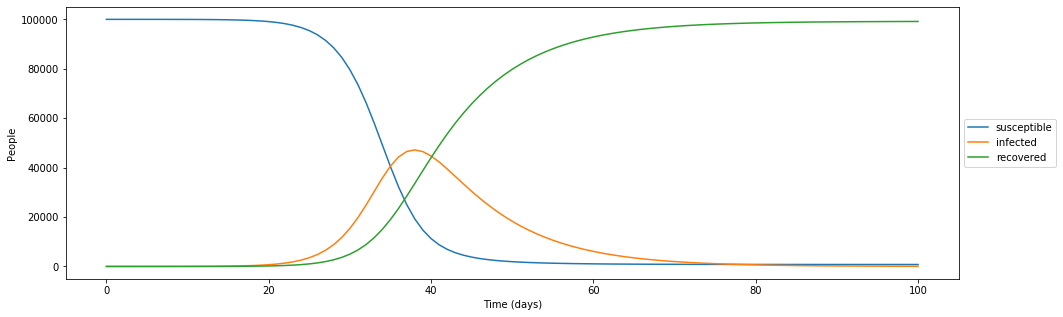

In [9]:
sir = experiments[simulations[0]:simulations[1]] 
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(sir['timestep'], sir['susceptible'], label='susceptible'  )
ax.plot(sir['timestep'], sir['infected'], label='infected'   )
ax.plot(sir['timestep'], sir['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### Covid-19 SEIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - \gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma*Infected
\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1/D)
- $\delta$ expected rate that exposed people turn into infected



# Covid-19 SEIR model stock and flow diagram 
![covid-19 SEIR model mechanism](images/covid-19_seir_model_stock_flow.png)

# Covid-19 SEIR model mechanism 
![covid-19 SIR model mechanism](images/covid-19_seir_model.png)

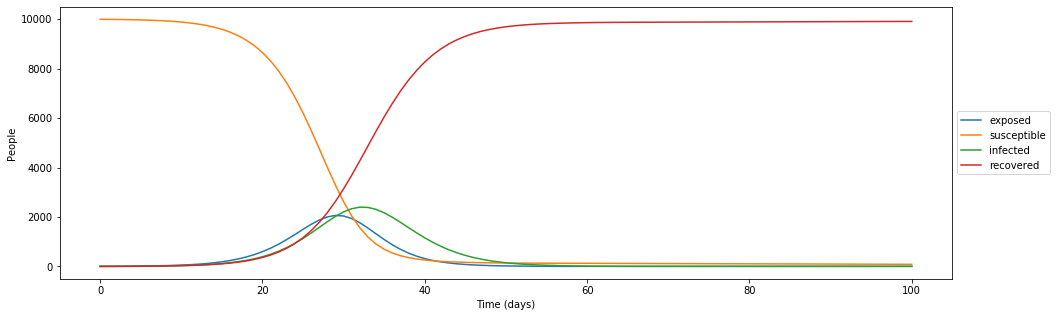

In [13]:
seir = experiments[simulations[1]:simulations[2]]  
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(seir['timestep'], seir['exposed'], label='exposed')
ax.plot(seir['timestep'], seir['susceptible'], label='susceptible')
ax.plot(seir['timestep'], seir['infected'], label='infected'   )
ax.plot(seir['timestep'], seir['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### Covid-19 SEIRD model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha * \rho * Infected
\\{\frac {d}{dt}Recovered}&= (1 - \alpha) * \gamma *Infected
\\{\frac {d}{dt}Dead}&=\alpha * \rho * Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1 / D)
- $\delta$ expected rate that exposed people turn into infected
- $\rho$ rate at wich infected people die per day ($\rho$ = 1 / D)
- $\alpha$ death probability
- $R₀$: the total number of people an infected person infects (R₀ = β / γ)


# Covid-19 SEIRD model stock and flow diagram 
![covid-19 SEIRD model mechanism](images/covid-19_seird_model_stock_flow.png)

# Covid-19 SEIRD model mechanism 
![covid-19 SEIRD model mechanism](images/covid-19_seird_model.png)

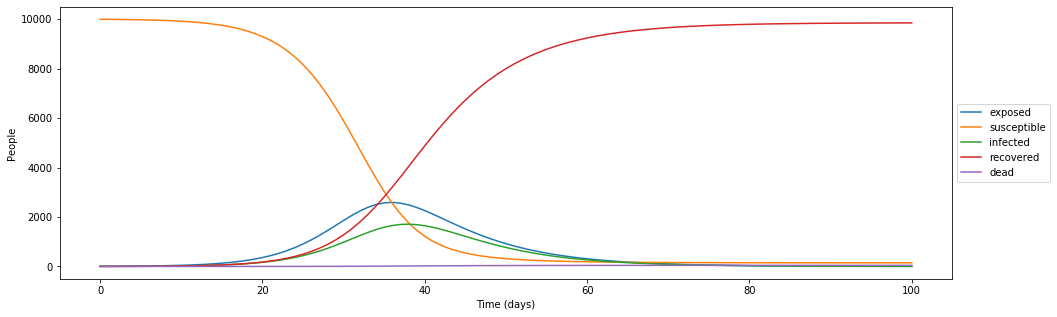

In [17]:
seird = experiments[simulations[2]:simulations[3]]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(seird['timestep'], seird['exposed'], label='exposed')
ax.plot(seird['timestep'], seird['susceptible'], label='susceptible')
ax.plot(seird['timestep'], seird['infected'], label='infected'   )
ax.plot(seird['timestep'], seird['recovered'], label='recovered')
ax.plot(seird['timestep'], seird['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### R₀ estimation from dataframe using SIR model

The idea is to read a dataframe with the information of susceptible, infected and recovered people and estimate R₀
\begin{aligned}\gamma(t) = {\frac {\frac {d}{dt}Recovered}{Infected}}
\\\beta(t) = {\frac {{\frac {d}{dt}Infected} + {\frac {d}{dt}Recovered}}{Infected * {\frac {Susceptible}{Total Population}}}}\end{aligned}


### Estimating R₀ from previous SIR model data

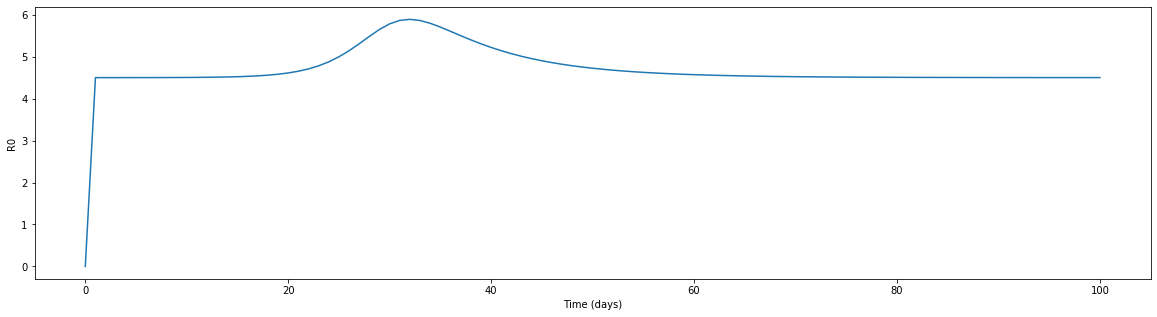

,susceptible,infected,recovered,simulation,run,substep,timestep,exposed,dead,r0,r0_estimation
303,0.0,0.0,0.0,3,1,0,0,0.0,0.0,1.0,0.000000
304,0.0,0.0,0.0,3,1,1,1,0.0,0.0,1.0,4.500225
305,0.0,0.0,0.0,3,1,1,2,0.0,0.0,1.0,4.500313
306,0.0,0.0,0.0,3,1,1,3,0.0,0.0,1.0,4.500434
307,0.0,0.0,0.0,3,1,1,4,0.0,0.0,1.0,4.500603
...,...,...,...,...,...,...,...,...,...,...,...
399,0.0,0.0,0.0,3,1,1,96,0.0,0.0,1.0,4.501186
400,0.0,0.0,0.0,3,1,1,97,0.0,0.0,1.0,4.501059
401,0.0,0.0,0.0,3,1,1,98,0.0,0.0,1.0,4.500945
402,0.0,0.0,0.0,3,1,1,99,0.0,0.0,1.0,4.500844


In [18]:
r0_estimation = experiments[simulations[3]:simulations[4]]
r0_estimation = r0_estimation.fillna(0)
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(r0_estimation['timestep'], r0_estimation['r0_estimation'], label='r0_estimation')
ax.set_xlabel("Time (days)")
ax.set_ylabel("R0")
plt.show()
r0_estimation

### Estimating R₀ from external data source (São Paulo, SP)

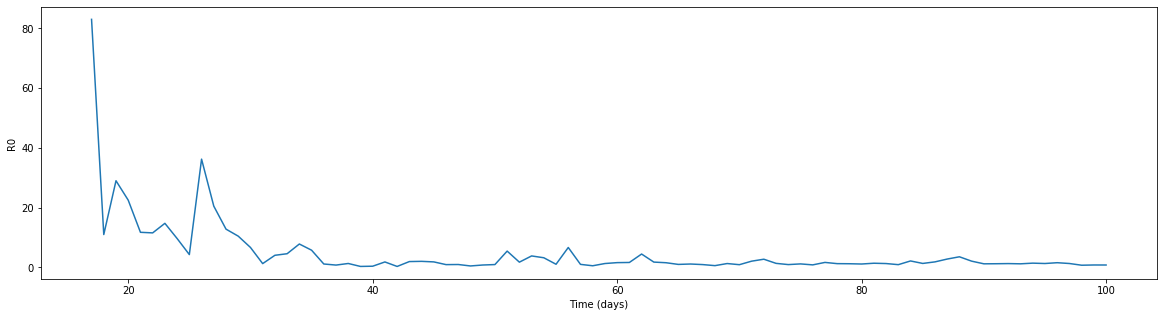

In [35]:
r0_estimation = experiments[simulations[4]:simulations[5]]
#r0_estimation = r0_estimation[90:]
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(r0_estimation['timestep'], r0_estimation['r0_estimation'], label='r0_estimation')
ax.set_xlabel("Time (days)")
ax.set_ylabel("R0")
plt.show()

### Importing Covid-19 data from Fiocruz

In [39]:
import requests
import json
import pandas as pd
pd.set_option('display.max_rows', None)
req = requests.get('https://brasil.io/api/dataset/covid19/caso/data?state=SP&city=São Paulo')
data = json.loads(req.text)
df = pd.DataFrame.from_dict(data['results'])
df.to_csv('sp_data_filter.csv')
df = df.iloc[::-1]
r0_estimation = df.filter(items=['estimated_population_19', 'confirmed', 'deaths', 'date'],axis=1)
r0_estimation.reset_index(drop=True, inplace=True)

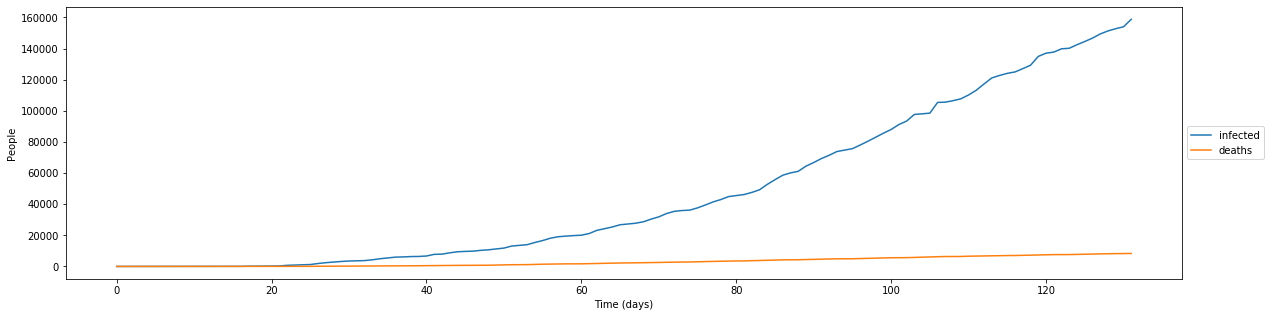

In [40]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"]=20,5
ax.plot(r0_estimation['confirmed'], label='infected')
ax.plot(r0_estimation['deaths'], label='deaths')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

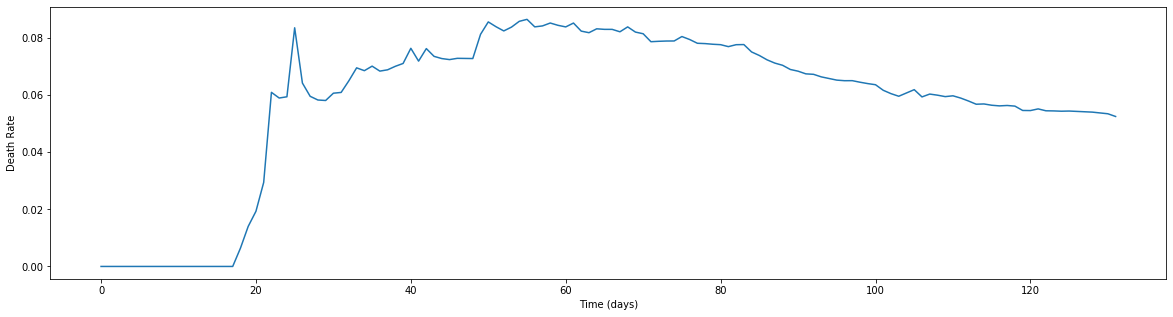

In [41]:
fig, ax = plt.subplots()
ax.plot(r0_estimation['deaths']/r0_estimation['confirmed'])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Death Rate")
plt.show()

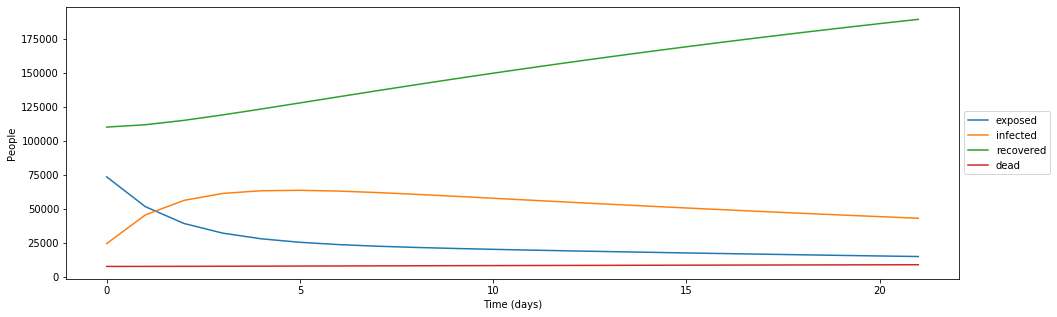

In [6]:
# R0 = 0.5
seird_predict_low = experiments[simulations[5]:simulations[6]]

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['exposed'], label='exposed')
#ax.plot(seird_predict_low['timestep'], seird_predict_low['susceptible'], label='susceptible')
ax.plot(seird_predict_low['timestep'], seird_predict_low['infected'], label='infected'   )
ax.plot(seird_predict_low['timestep'], seird_predict_low['recovered'], label='recovered')
ax.plot(seird_predict_low['timestep'], seird_predict_low['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

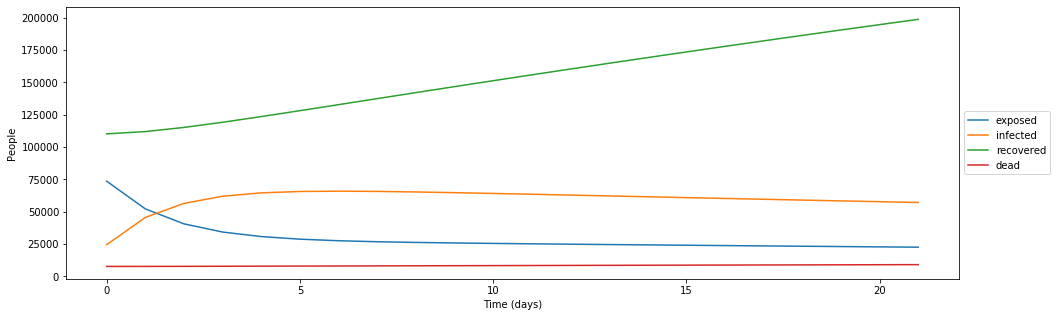

In [7]:
# R0 = 0.8
seird_predict = experiments[simulations[6]:simulations[7]] 

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict['timestep'], seird_predict['exposed'], label='exposed')
#x.plot(seird_predict_low['timestep'], seird_predict_low['susceptible'], label='susceptible')
ax.plot(seird_predict['timestep'], seird_predict['infected'], label='infected'   )
ax.plot(seird_predict['timestep'], seird_predict['recovered'], label='recovered')
ax.plot(seird_predict['timestep'], seird_predict['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

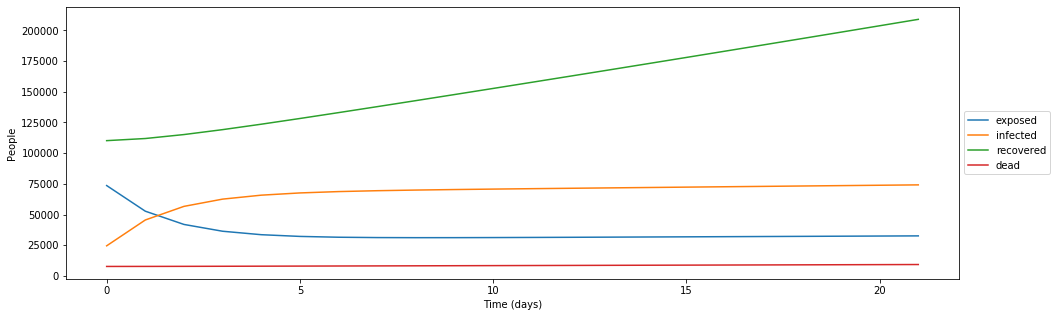

In [10]:
# R0 = 1.1
seird_predict_high = experiments[simulations[7]:] 

plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(seird_predict_high['timestep'], seird_predict_high['exposed'], label='exposed')
#x.plot(seird_predict_high['timestep'], seird_predict_high['susceptible'], label='susceptible')
ax.plot(seird_predict_high['timestep'], seird_predict_high['infected'], label='infected'   )
ax.plot(seird_predict_high['timestep'], seird_predict_high['recovered'], label='recovered')
ax.plot(seird_predict_high['timestep'], seird_predict_high['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

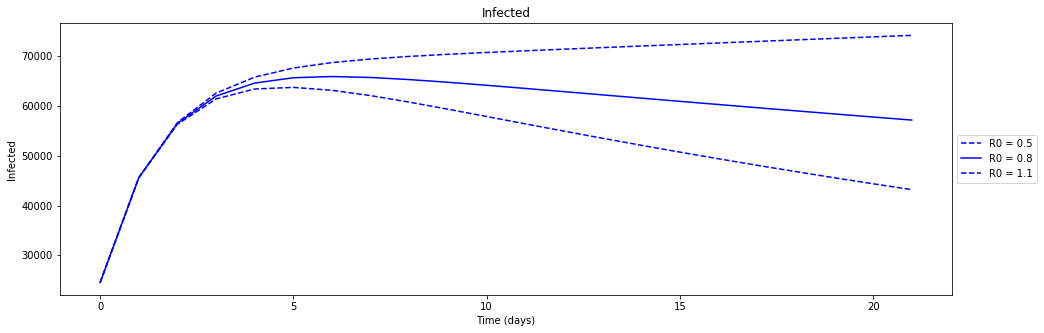

In [11]:
# Infected

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['infected'], 'b--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['infected'], 'b', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['infected'], 'b--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("Infected")
plt.title("Infected")
plt.show()

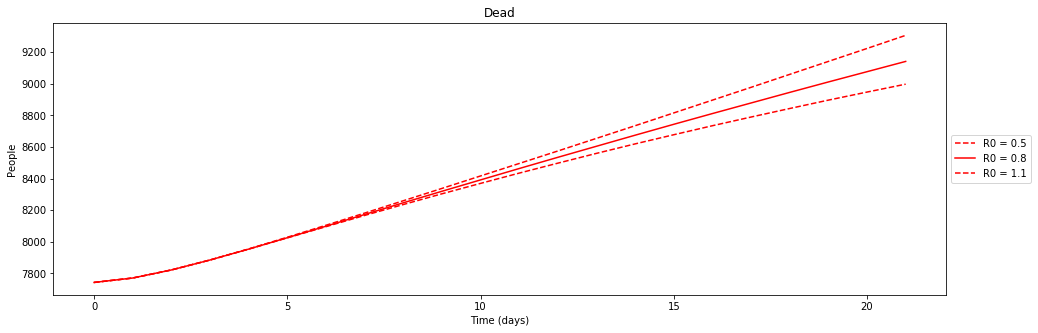

In [12]:
# Dead

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['dead'],'r--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['dead'], 'r', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['dead'], 'r--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.title("Dead")
plt.show()

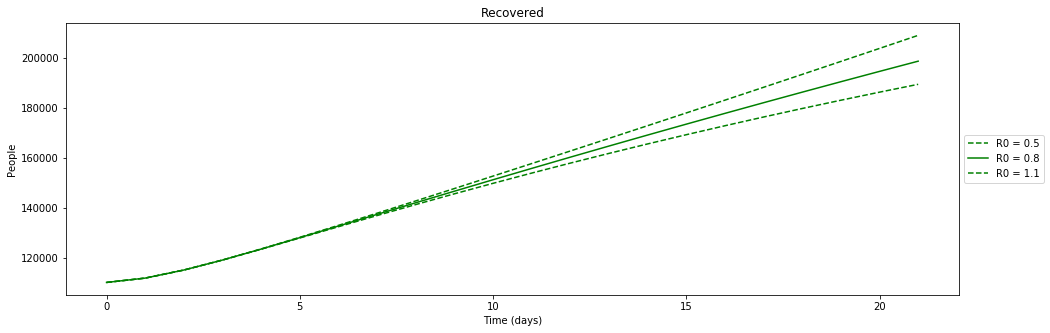

In [13]:
# Recovered

fig, ax = plt.subplots()
ax.plot(seird_predict_low['timestep'], seird_predict_low['recovered'], 'g--', label='R0 = 0.5')
ax.plot(seird_predict_low['timestep'], seird_predict['recovered'], 'g', label='R0 = 0.8')
ax.plot(seird_predict_low['timestep'], seird_predict_high['recovered'], 'g--', label='R0 = 1.1')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.title("Recovered")
plt.show()

### Conclusions and final words

### Proposed challenges

#### Make R₀ time dependent


#### Variable death rate



#### Stochasticity of the parameters



#### Add real data

